In [1]:
import Pkg
Pkg.activate("../../");

  Activating project at `C:\SY\MIT\UROP\InverseGraphics\InverseGraphics`


In [2]:
import Revise
import GLRenderer as GL
import Images as I
import MiniGSG as S
import Rotations as R
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
import InverseGraphics as T
import NearestNeighbors
import LightGraphs as LG
import StaticArrays
import ProgressMeter
import Serialization
using Distributions
import Gen
using Plots
using ProgressMeter
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

In [3]:
# # Initialize the renderer
V.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8715
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


Process(`cmd.exe /C 'start http://127.0.0.1:8715'`, ProcessExited(0))

In [4]:
# Loading the YCB object models
YCB_DIR = joinpath(dirname(dirname(pwd())),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
all_ids = sort(collect(keys(id_to_cloud)));
names = T.load_ycb_model_list(YCB_DIR)

21-element Vector{String}:
 "002_master_chef_can"
 "003_cracker_box"
 "004_sugar_box"
 "005_tomato_soup_can"
 "006_mustard_bottle"
 "007_tuna_fish_can"
 "008_pudding_box"
 "009_gelatin_box"
 "010_potted_meat_can"
 "011_banana"
 "019_pitcher_base"
 "021_bleach_cleanser"
 "024_bowl"
 "025_mug"
 "035_power_drill"
 "036_wood_block"
 "037_scissors"
 "040_large_marker"
 "051_large_clamp"
 "052_extra_large_clamp"
 "061_foam_brick"

In [5]:
# Initialize the canera intrinsics and renderer that will render using those intrinsics.
camera = GL.CameraIntrinsics()
camera = T.scale_down_camera(camera, 5.5)
camera_pose = IDENTITY_POSE

renderer = GL.setup_renderer(camera, GL.DepthMode())
resolution = 0.05

@show camera;

gl_version_for_shaders = "460"
true
camera = GLRenderer.CameraIntrinsics
  width: Int64 116
  height: Int64 87
  fx: Float64 116.36363636363636
  fy: Float64 116.36363636363636
  cx: Float64 58.18181818181818
  cy: Float64 43.63636363636363
  near: Float64 0.001
  far: Float64 100.0



In [6]:

# Load a cube (id = 1) and all ycb objects
# box_mesh = GL.box_mesh_from_dims([2.0, 2.0, 2.0])
# GL.load_object!(renderer, box_mesh)

for id in all_ids
    cloud = id_to_cloud[id]
    mesh = GL.mesh_from_voxelized_cloud(GL.voxelize(cloud, resolution), resolution);
    GL.load_object!(renderer, mesh)
end

@show length(all_ids)

length(all_ids) = 21


21

## introductory visualizations
to get a better sense of resolution effect on likelihood + qualitative results 

true


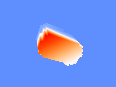

names[i] = "010_potted_meat_can"


3×38 Matrix{Float64}:
 -0.44   0.285  -0.15  0.125  0.03   0.355  …  -0.115   0.42   -0.595  0.235
  0.16   0.21    0.29  0.365  0.34   0.155      0.02   -0.13   -0.165  0.04
  2.625  2.67    2.62  2.705  2.675  2.675      2.51    3.005   3.185  2.6

In [7]:
#########
# radius scaling
#########
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,100.0)

i = 9 #rand(all_ids)
pose = Pose([0.0, 0.0, 3.0], R.RotXYZ(0.4, -0.2, 0.4))

# Reset the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera) 

# And render the same image as above.
gt_depth_image = GL.gl_render(renderer, [i], [pose], camera_pose)
IJulia.display(GL.view_depth_image(gt_depth_image))

# Create point cloud corresponding to that rendered depth image.
gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera)
# print(size(gt_cloud))


@show names[i]

radius = 0.01  # "tight" radius
sampled_cloud = T.voxelize(Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds), 0.005)
# Visualize that point cloud.
# V.setup_visualizer()
# V.viz(sampled_cloud, color=I.colorant"red", channel_name=:origin)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))


# function move_points_to_frame_b(points_in_frame_a::Matrix{<:Real}, b_relative_to_a::Pose)
#     if size(points_in_frame_a)[1] != 3
#         error("expected an 3 x n matrix")
#     end
#     n = size(points_in_frame_a[2])
#     return b_relative_to_a.orientation * points_in_frame_a .+ b_relative_to_a.pos
# end

 
# radius = float(1)  # "loose" radius (can still pick out general shape)
# sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # Visualize that point cloud.
# # V.setup_visualizer()
# # V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

 
# radius = float(10)  # very loose radius; points on a sphere (w/ some concentration on center with shape of obj)
# sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # # Visualize that point cloud.
# # V.setup_visualizer()
# # V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

In [8]:
# ########
# # camera downscaling
# ########
# using IJulia

# final = 24
# for downscale_factor=1:3.0:final
#     println("scale down by $downscale_factor")
    
#     # scale camera according to resolution; reset renderer
#     scaled_camera = GL.scale_down_camera(camera, downscale_factor)
        
#     # Set the renderer to now have those scaled down intrinsics.
#     GL.set_intrinsics!(renderer, scaled_camera)
 
#     d = GL.gl_render(renderer, [i], [pose], IDENTITY_POSE)

#     img = GL.view_depth_image(d)
#     img = I.imresize(img, (camera.height, camera.width));
#     IJulia.display(img)
  
#     # revert intrinsics
#     GL.set_intrinsics!(renderer, camera)

# end


# Intro demo of coarse-to-fine with particle filtering

## Particle Filtering + Orientation enumeration

### Cloud visualization / generation helpers

In [9]:
function viz_trace(trace)
    V.setup_visualizer()
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=:gen);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=:obs);
end

viz_trace (generic function with 1 method)

In [10]:
# Helper function to get point cloud from the object ids, object poses, and camera pose
# (see demo.jl)
function get_cloud_nocache(poses, ids)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, renderer.camera_intrinsics)
    if isnothing(cloud)
        cloud = zeros(3,1)
    else
        cloud = T.move_points_to_frame_b(cloud, camera_pose)
    end
    cloud
end

get_cloud_nocache (generic function with 1 method)

In [11]:
function get_cloud_func_cached(p, id)
    idx1 = argmin(sum((dirs .- (p.orientation * [1,0,0])).^2, dims=1))[2]
    idx2 = argmin([abs(R.rotation_angle(inv(p.orientation) * r)) for r in rotations_to_enumerate_over[idx1,:]])
    # closest_orientation = rotations_to_enumerate_over[idx1,idx2]
    c = T.move_points_to_frame_b(cloud_lookup[id][idx1,idx2], p)
end

get_cloud_func_cached (generic function with 1 method)

In [12]:
# # test caching vs cloud

# # Render depth from random id, pose
# test_id, test_pose = rand(all_ids), T.uniformPose(-3.0, 3.0, -2.0, 2.0, 6.0, 12.0)
# gt_depth = T.GL.gl_render(renderer, [test_id], [test_pose], IDENTITY_POSE);
# # Convert to point cloud.
# # gt_cloud = T.GL.depth_image_to_point_cloud(gt_depth, camera)

# cached_cloud = get_cloud_func_cached(test_pose, test_id);
# non_cached_cloud = get_cloud_nocache([test_pose], [test_id]);

# V.setup_visualizer()
# V.viz(T.voxelize(cached_cloud, 0.005)  ./ 10.0; color=I.colorant"red", channel_name=:gen);
# V.viz(T.voxelize(non_cached_cloud, 0.005)./ 10.0; color=I.colorant"blue", channel_name=:obs);

In [13]:
# generate cached renderings of all objects at all rotations, positioned at reference frame
function generate_cloud_cache()
    cloud_lookup = []
    @showprogress for id in all_ids
        cloud = 
        [
            let
                position = [0.0, 0.0, 10.0]
                pose = Pose(position, rotations_to_enumerate_over[i,j])
                d = T.GL.gl_render(renderer, [id], [pose], IDENTITY_POSE);
                c = T.GL.depth_image_to_point_cloud(d, camera)
                c = T.get_points_in_frame_b(c, pose)  # gets the cloud in the render pose reference frame
            end
            for i = 1:size(rotations_to_enumerate_over,1), j = 1:size(rotations_to_enumerate_over,2)
        ]
        push!(cloud_lookup, cloud)    
    end 
    
    return cloud_lookup
end


generate_cloud_cache (generic function with 1 method)

### Model helpers

In [14]:
function icp_move_no_unexplained(trace, i, inf_radius, renderer, cam_pose; iterations=10)
    # get_cloud_func needs to give the points in the world frame
#     get_cloud_func = (poses, ids, cam_pose) -> get_cloud_nocache([poses], [ids])  
    get_cloud_func = (pose, id, cam_pose) -> get_cloud_func_cached(pose, id);

    id = Gen.get_choices(trace)[:id]  
    addr = T.floating_pose_addr(1)
    
    obs_cloud = T.move_points_to_frame_b(T.get_obs_cloud(trace), cam_pose)
    c1_tree = NearestNeighbors.KDTree(obs_cloud);

    refined_pose = trace[addr]
    
    refined_pose = T.icp_object_pose(
        refined_pose,
        obs_cloud,
        p -> T.voxelize(get_cloud_func(p, id, cam_pose), v_resolution(inf_radius)),
        c1_tree=c1_tree,
        iterations=iterations
    );

    acceptances = false
     
    for _ in 1:iterations
        trace, acc = T.pose_mixture_move(
            trace, addr, [trace[addr], refined_pose], [0.5, 0.5], 1e-2, 5000.0
        )
        acceptances = acc || acceptances
    end
    
    trace, acceptances, refined_pose
end

icp_move_no_unexplained (generic function with 1 method)

In [62]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state_from_enum(scored_traces, num_particles, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)#(t -> t[2]).(scored_traces)  
    
    _, norm_log_weights = Gen.normalize_weights(log_weights)       
    
    # sample initial set of particles
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles)
    selected_log_weights = Vector{Float64}(undef, num_particles)
    for i=1:num_particles
        trace_idx = Gen.random(Gen.categorical, exp.(norm_log_weights))   
        selected_traces[i] = traces[trace_idx]
        selected_log_weights[i] = norm_log_weights[trace_idx]
    end
    
    println("Initial particle state computed"); flush(stdout)

#     # visualize pdf of initial weights (?)
#     plot(selected_log_weights, seriestype=:stephist, fmt = :png)
    
    # see intermediate results
    top_n = min(5, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];
#     if vis
#         viz_trace(best_trace);
#     end
    println("top$top_n traces:")
    for idx in p
       println("curr_weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(selected_traces[idx]).ori), " id=", Gen.get_retval(selected_traces[idx]).id) 
    end
    flush(stdout)
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state_from_enum

In [63]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state(scored_traces, num_particles, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)#(t -> t[2]).(scored_traces)  
    
     _, norm_log_weights = Gen.normalize_weights(log_weights)    
    flush(stdout)
    
    # sample initial set of particles
    num_particles_per_obj = num_particles ÷ num_candidate_objs
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles_per_obj * num_candidate_objs)
    selected_log_weights = Vector{Float64}(undef, num_particles_per_obj * num_candidate_objs)
        
    stepsize = num_rotations_to_enumerate_over ÷ num_candidate_objs
    for i=0:num_candidate_objs-1
        for j = 1:num_particles_per_obj
            trace_idx = stepsize * i + 
                        Gen.random(Gen.categorical, 
                        exp.(Gen.normalize_weights(log_weights[stepsize*i+1:stepsize*(i+1)])[2]))   
            selected_traces[num_particles_per_obj*i+j] = traces[trace_idx]
            selected_log_weights[num_particles_per_obj*i+j] = norm_log_weights[trace_idx]
        end        
    end
     
    
    println("Initial particle state computed ($num_particles_per_obj particles per object)"); flush(stdout)

    
    # see intermediate results
    top_n = min(10, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];
#     if vis
#         viz_trace(best_trace);
#     end
    if topnprint
        println("top$top_n traces:")
        for idx in p
           println("curr_weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(selected_traces[idx]).ori), " id=", Gen.get_retval(selected_traces[idx]).id) 
        end
        flush(stdout)
    end
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state

consider doing 20x random pose initialization+ICP moves

In [17]:
"""adapted from gen pf_step:
Perform a particle filter update, where the model arguments are adjusted, new observations are added, and the default proposal is used for new latent state.
"""
function particle_filter_step!(state::Gen.ParticleFilterState{U}, new_args::Tuple, argdiffs::Tuple,
        observations) where {U}    
    log_incremental_weights = Vector{Float64}(undef, num_particles) 
    radius::Float64 = new_args[1]
#     centroid::Vector{Float64} = new_args[end]
    
    @Threads.threads for i=1:num_particles
    ## do mh, drift moves, etc. tune particle before update (i.e. new likelihood)
        state.traces[i], acc, _ = icp_move_no_unexplained(state.traces[i], Gen.get_retval(state.traces[i]).id, 
                                            radius, renderer, camera_pose; iterations=15)

        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 500.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 1000.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 1000.0)
        
        
        # evolve the particle (with new radius involved in new_args)
        (state.new_traces[i], increment, _, discard) = Gen.update(
            state.traces[i], new_args, argdiffs, observations)
#         if !isempty(discard)
#             error("Choices were updated or deleted inside particle filter step: $discard")
#         end
        log_incremental_weights[i] = increment
        state.log_weights[i] += increment
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp
    
    return log_incremental_weights
end

particle_filter_step!

In [18]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,300.0)

v_resolution = radius -> radius * 0.6  # distance between two points on the pointcloud 

"""sample point clouds at the given camera resolution and radius"""
Gen.@gen function model(radius, renderer, centroid)
    
    # sample object id
    i = {:id} ~ Gen.categorical(fill(1.0/num_candidate_objs, (num_candidate_objs,)))
    
    # sample pose
    xc, yc, zc = centroid
    delta = 0.9
    p = {T.floating_pose_addr(1)} ~ T.uniformPose(xc-delta, xc+delta, yc-delta, yc+delta, zc-delta, zc+delta)
#     gt_cloud = get_cloud_nocache([p], [i])    
    gt_cloud = get_cloud_func_cached(p, i);

    voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
    obs_cloud = {T.obs_addr()} ~ T.uniform_mixture_from_template(voxelized_cloud, 0.0001, radius, bounds)
         
    (id=i, pose=p, pos=p.pos, ori=p.orientation, cloud=gt_cloud, voxelized_cloud=voxelized_cloud, rendered_clouds=[voxelized_cloud], obs_cloud=obs_cloud)

end
 

model

### control resolution with radius (fixed camera intrinsics)

In [64]:
"""Particle filter on the evolution of agent knowledge over time; resolution control with radius"""
function particle_filter(renderer, init_radius::Float64, final_radius::Float64, radius_step::Float64, scored_traces,
                        gt_obj_id::Int, gt_pose::Pose, centroid, num_particles::Int, num_samples::Int, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    
    # initialize renderer and particle filter
    GL.set_intrinsics!(renderer, camera)  
#     gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
    gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id)
    gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))
    
    println("\ninitializing particle filter at radius $init_radius") 
    flush(stdout)
    
    
    # initialize a state of initial particles with various rotations  
#     state::Gen.ParticleFilterState{U} = generate_initial_pf_state_from_enum(scored_traces, num_particles)
    state::Gen.ParticleFilterState{U} = generate_initial_pf_state(scored_traces, num_particles)

    
    # evolve over resolutions (modify sphere radius `r` of mixture point cloud likelihood)
    @assert(radius_step < 0.0)
    best_trace = Nothing
    for radius in init_radius+radius_step:radius_step:final_radius-eps()
        println("\n========Radius=$radius========"); flush(stdout)
        Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)  
        
        # update pf 
        gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
        observations = Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, :id => gt_obj_id) 
        current_log_weights = particle_filter_step!(state, (radius, renderer, centroid),   
                                                    (Gen.UnknownChange(),), observations)    
        
        # see intermediate results
        top_n = min(5, num_particles-1)
        _, norm_log_weights = Gen.normalize_weights(current_log_weights)
        p = sortperm(norm_log_weights)[end-top_n:end]; 
        
        best_trace = state.traces[argmax(norm_log_weights)];
    
        if topnprint
            println("top$top_n traces:")
            for idx in p
               println("weight=", norm_log_weights[idx], " ori=", (Gen.get_retval(state.traces[idx]).ori)[1:3], "  id=", Gen.get_retval(state.traces[idx]).id) 
            end
            flush(stdout)
        end
        
    end;
    if vis
        viz_trace(best_trace);
    end
    
    # normalize final weights
    log_total_weight, norm_weights = Gen.normalize_weights(state.log_weights)
    return [norm_weights, Gen.sample_unweighted_traces(state, num_samples)]
    
end

particle_filter

In [65]:
## Control rotation enumeration / update render cache

unit_sphere_directions = T.fibonacci_sphere(60);
other_rotation_angle = collect(0:0.24:(2*π));
rotations_to_enumerate_over = [
    let
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir...), ang, 1)
    end
    for dir in unit_sphere_directions, 
        ang in other_rotation_angle
];
@show num_rotations_to_enumerate_over = length(rotations_to_enumerate_over)
dirs = hcat(unit_sphere_directions...)

# cloud_lookup = generate_cloud_cache()
# Serialization.serialize("render_caching_data.data", (cloud_lookup, rotations_to_enumerate_over, unit_sphere_directions, other_rotation_angle, dirs))
# @show length(cloud_lookup)

(cloud_lookup, rotations_to_enumerate_over, unit_sphere_directions, other_rotation_angle, dirs) = 
Serialization.deserialize("render_caching_data_200_10.data");

num_rotations_to_enumerate_over = length(rotations_to_enumerate_over) = 1620


InterruptException: InterruptException:

In [33]:
reduced_rotations_to_enumerate_over = rotations_to_enumerate_over[1:5:end][1:5:end];

In [67]:
function precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, num_candidate_objs, rotations_to_enumerate_over)
    # initialize a state of initial particles with various rotations
    all_scored_traces = []
    x, y, z = gt_pose.pos
    gt_position = [x,y,z]
    @Threads.threads for obj_id=1:num_candidate_objs
        scored_traces = map(orn -> 
                        Gen.generate(model, (init_radius, renderer, gt_position),                 
                                    Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
                                                :id => obj_id, 
                                                T.floating_pose_addr(1) => Pose(gt_position, orn))),
                                    rotations_to_enumerate_over[:]);
    
        all_scored_traces = vcat(all_scored_traces, scored_traces)
    end
    return all_scored_traces
    
end 

 
final_radius = float(0.01)# low to high "focus"
init_radius = float(0.15)  # high num = faster enum





0.15

In [68]:
# enumeration example
num_candidate_objs = length(all_ids)  #set to 1 for fixed object id

@show gt_obj_id = rand(1:num_candidate_objs)
@show object = names[gt_obj_id]
 
# get GT data (to infer)
gt_position = [0.0, 0.0, 5.0]
tr, _ = Gen.generate(model, (init_radius, renderer, gt_position), Gen.choicemap(:id => gt_obj_id))
gt_pose = T.Pose(pos=gt_position, orientation=Gen.get_retval(tr).ori)

# gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id);
gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))

# get centroid (at a finer resolution)
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1e-10)))


@time enum_ori_traces = precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, 
    num_candidate_objs, reduced_rotations_to_enumerate_over);
@show num_rotations_to_enumerate_over = length(enum_ori_traces)

gt_obj_id = rand(1:num_candidate_objs) = 17
object = names[gt_obj_id] = "037_scissors"
 20.956597 seconds (13.64 M allocations: 1.549 GiB, 83.77% gc time, 3.08% compilation time)
num_rotations_to_enumerate_over = length(enum_ori_traces) = 10584


10584

In [46]:
num_particles_per_obj = 4
num_particles = num_particles_per_obj * num_candidate_objs
@show num_samples = num_particles
num_steps = 2
radius_step = (final_radius - init_radius)/num_steps


num_samples = num_particles = 84


-0.125

### single object trial

In [69]:


# precompute enumeration; run the below code once and comment out
num_candidate_objs = length(all_ids)  #set to 1 for fixed object id

@show gt_obj_id = rand(1:num_candidate_objs)
@show object = names[gt_obj_id]
 
# get GT data (to infer)
gx, gy, gz = Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0)
@show gt_position = [gx, gy, gz]
tr, _ = Gen.generate(model, (init_radius, renderer, gt_position), Gen.choicemap(:id => gt_obj_id))
gt_pose = T.Pose(pos=gt_position, orientation=Gen.get_retval(tr).ori)

# gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id);
gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))

# get centroid (at a finer resolution)
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1e-10)))


@time enum_ori_traces = precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, 
    num_candidate_objs, reduced_rotations_to_enumerate_over);



topnprint, vis = false, true  # print top particles / meshcat viz
@time weights, pf_traces = particle_filter(renderer, init_radius, final_radius, radius_step,
                                    enum_ori_traces, gt_obj_id, gt_pose, centroid, num_particles, num_samples);


gt_obj_id = rand(1:num_candidate_objs) = 3
object = names[gt_obj_id] = "004_sugar_box"
gt_position = [gx, gy, gz] = [4.04676473332689, 3.9002158426093563, 3.5289651325127696]
  3.082255 seconds (13.57 M allocations: 1.613 GiB)
true

initializing particle filter at radius 0.15
Initial particle state computed (4 particles per object)

========Radius=0.024999999999999994========
effective sample size: 4.0, doing resample: true
  5.798722 seconds (8.63 M allocations: 1.156 GiB, 28.58% gc time)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8766
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


In [44]:
function error(object_cloud, ground_truth_pose, predicted_pose)
    tree = NearestNeighbors.KDTree(T.move_points_to_frame_b(object_cloud, predicted_pose))
    _, dists = NearestNeighbors.nn(tree, T.move_points_to_frame_b(object_cloud, ground_truth_pose))
    sum(dists) ./ length(dists)
end

error (generic function with 1 method)

In [45]:
# error eval
obj_cloud = id_to_cloud[gt_obj_id] 

@time @show error(obj_cloud, gt_pose, (Gen.get_retval(pf_traces[argmax(weights)]).pose))
# @time @show error(obj_cloud, T.IDENTITY_POSE, p1)
# @time @show error(obj_cloud, p1, p1)
# @time @show error(obj_cloud, T.IDENTITY_POSE, T.IDENTITY_POSE)

error(obj_cloud, gt_pose, (Gen.get_retval(pf_traces[argmax(weights)])).pose) = 0.11440277929460603
  0.385244 seconds (936.53 k allocations: 80.856 MiB, 97.63% compilation time)


0.11440277929460603

## Pose-Only Test

In [28]:
num_trials_per_obj = 25
pose_results_dict = Dict("time" => Dict(), "avg_errors" => Dict())

Dict{String, Dict{Any, Any}} with 2 entries:
  "time"       => Dict()
  "avg_errors" => Dict()

In [54]:
for gt_obj_id=17:21
    accuracy = 0
    pose_err = 0
    valid = 0
    pose_results_dict["avg_errors"][gt_obj_id] = 0

    obj_cloud = id_to_cloud[gt_obj_id] 

    pose_results_dict["time"][gt_obj_id] = @elapsed for ii=1:num_trials_per_obj

        # precompute enumeration; run the below code once and comment out
        num_candidate_objs = length(all_ids)  #set to 1 for fixed object id

        # get GT data (to infer)
        gx, gy, gz = Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0)
        gt_position = [gx, gy, gz]
        tr, _ = Gen.generate(model, (init_radius, renderer, gt_position), Gen.choicemap(:id => gt_obj_id))
        gt_pose = T.Pose(pos=gt_position, orientation=Gen.get_retval(tr).ori)

        # gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
        gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id);
        gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))

        # get centroid (at a finer resolution)
        centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1e-10)))


        @time enum_ori_traces = precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, 
                            num_candidate_objs, reduced_rotations_to_enumerate_over);

        try
            @time weights, pf_traces = particle_filter(renderer, init_radius, final_radius, radius_step,
                                                enum_ori_traces, gt_obj_id, gt_pose, centroid, num_particles, num_samples);
            pose_err += error(obj_cloud, gt_pose, (Gen.get_retval(pf_traces[argmax(weights)]).pose))
            valid += 1
        catch BoundsError  #result of precompute_enumerations with low # rotations
            accuracy += 0
        end
        println("$pose_err/$valid"); flush(stdout);
    end

    @show pose_results_dict["avg_errors"][gt_obj_id] = pose_err / valid
end

  0.256049 seconds (10.71 M allocations: 1.295 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.000000000000201, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.4660287130946312, doing resample: true
  0.675735 seconds (14.52 M allocations: 1.822 GiB)
0.01815172498904807/1
  1.268725 seconds (10.66 M allocations: 1.282 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.000564664009834, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 4.113484687167778, doing resample: true
  2.339094 seconds (10.84 M allocations: 1.451 GiB, 82.54% gc time)
0.028169530889219398/2
  0.381723 seconds (10.63 M allocations: 1.294 GiB)
true

initializing particle filter at radius 0.3
Initial particle 

effective sample size: 3.7207139868339265, doing resample: true
  0.874239 seconds (14.16 M allocations: 1.826 GiB)
0.8692151698479673/19
  3.317810 seconds (10.71 M allocations: 1.310 GiB, 58.58% gc time)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.0000081137011705, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 2.8530533931960087, doing resample: true
  0.699851 seconds (16.22 M allocations: 2.077 GiB)
0.8803480413588741/20
  0.659575 seconds (10.69 M allocations: 1.295 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 2.694093799525711, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.0000234273749686, doing resample: true
  5.938256 seconds (13.18 M allocations: 1.808 GiB, 5

Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 5.222451410141459, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 2.980510765518711, doing resample: true
  0.539372 seconds (10.90 M allocations: 1.308 GiB)
0.17782259090938735/13
  1.043222 seconds (10.83 M allocations: 1.304 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 7.059168760478604, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 7.844228394291854, doing resample: true
  2.684419 seconds (13.96 M allocations: 1.733 GiB, 62.56% gc time)
0.18805889978400697/14
  0.404592 seconds (10.70 M allocations: 1.293 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 2.182989

effective sample size: 1.4687569983783304, doing resample: true
  5.002381 seconds (17.87 M allocations: 2.300 GiB, 55.87% gc time)
0.2872595131715976/6
  0.403488 seconds (11.09 M allocations: 1.372 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 3.913097276429871, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.6025023065704724, doing resample: true
  2.281854 seconds (17.84 M allocations: 2.306 GiB)
0.29693882454451376/7
  3.760116 seconds (10.96 M allocations: 1.338 GiB, 75.87% gc time)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.0, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 2.131567035062449, doing resample: true
  0.821787 seconds (14.75 M allocations: 1.937 GiB)
0.


========Radius=0.175========
effective sample size: 4.000100140939007, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.0000000000034106, doing resample: true
  0.513101 seconds (14.04 M allocations: 1.998 GiB)
1.2764886301143115/25
(pose_results_dict["avg_errors"])[gt_obj_id] = pose_err / valid = 0.05105954520457246
  0.643513 seconds (10.98 M allocations: 1.352 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.0, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.1159153116354399, doing resample: true
  5.171472 seconds (16.57 M allocations: 2.191 GiB, 52.01% gc time)
0.1374267262039919/1
  0.386726 seconds (10.87 M allocations: 1.338 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample 

Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 3.986284123393709, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.0000000000004547, doing resample: true
  4.040263 seconds (16.09 M allocations: 2.265 GiB, 58.63% gc time)
1.8675348491641302/19
  0.526684 seconds (11.15 M allocations: 1.426 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 4.00000000000003, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.000000000295131, doing resample: true
  5.934827 seconds (16.03 M allocations: 2.364 GiB, 52.67% gc time)
2.0244134245147687/20
  0.439475 seconds (11.25 M allocations: 1.443 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample 

effective sample size: 1.5364264220520598, doing resample: true
  0.771044 seconds (14.58 M allocations: 1.912 GiB)
0.19666083481333096/12
  1.235637 seconds (10.87 M allocations: 1.324 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 7.122476551688047, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 2.1178527428193754, doing resample: true
  2.415369 seconds (14.84 M allocations: 1.888 GiB, 73.95% gc time)
0.22424866024583556/13
  0.477327 seconds (10.86 M allocations: 1.328 GiB)
true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)

========Radius=0.175========
effective sample size: 5.9251077684458995, doing resample: true

========Radius=0.04999999999999999========
effective sample size: 1.13693253614483, doing resample: true
  2.739148 seconds (15.43 M allocations: 1.959 GiB)
0

In [70]:
pose_results_dict["avg_errors"]


# import JLD
# JLD.save("pose_results_dict_$init_radius-$final_radius-$num_steps.jld", "results", pose_results_dict)  # TODO: doesnt work when jld?


Dict{Any, Any} with 21 entries:
  5  => 0.0316833
  16 => 0.0224897
  20 => 0.103484
  12 => 0.0679598
  8  => 0.0234738
  17 => 0.0445632
  1  => 0.0187724
  19 => 0.0510595
  6  => 0.0151963
  11 => 0.0999579
  9  => 0.0295003
  14 => 0.0337184
  3  => 0.0281811
  7  => 0.0294625
  4  => 0.104224
  13 => 0.0150055
  15 => 0.0532828
  2  => 0.0348473
  10 => 0.0342685
  18 => 0.014807
  21 => 0.0180741

0.3

In [26]:
# xyz = [
#     rotations_to_enumerate_over[i,1] * [1, 0, 0]
#     for i in 1:size(rotations_to_enumerate_over)[1] 
# ];
# log_weights_xyz = zeros(size(rotations_to_enumerate_over)[1])
# weights_xyz = exp.(log_weights_xyz)
# order = sortperm(weights_xyz,rev=true)
# weights_xyz = weights_xyz[order]
# xyz = xyz[order]
# weights_xyz


In [27]:
# using PyCall
# using PyPlot

# plt = pyimport("matplotlib.pyplot")
# mpl_toolkits = pyimport("mpl_toolkits")
# x = range(0;stop=2*pi,length=1000); y = sin.(3*x + 4*cos.(2*x));
# plot(x, y, color="red", linewidth=2.0, linestyle="--")
# # plt.show()

# function run_viz(x, y, z, c)
#     fig = plt.figure(figsize=(9, 6))
#     ax = plt.axes(projection="3d")
#     ax.scatter3D(x, y, z, c=c)
#     p = ax.set_title("3D scatterplot", pad=25, size=15)
#     ax.set_xlabel("X") 
#     ax.set_ylabel("Y") 
#     ax.set_zlabel("Z")
#     plt.show()
# end



# # PyCall.py"""
# # import matplotlib.pyplot as plt
# # from mpl_toolkits import mplot3d
# # def run_viz(x,y,z,c):
# #     fig = plt.figure(figsize=(9, 6))
# #     ax = plt.axes(projection='3d')
# #     ax.scatter3D(x, y, z, c=c)
# #     p = ax.set_title("3D scatterplot", pad=25, size=15)
# #     ax.set_xlabel("X") 
# #     ax.set_ylabel("Y") 
# #     ax.set_zlabel("Z")
# #     plt.show()
# # """

# run_viz( (i->i[1]).(xyz), (i->i[2]).(xyz), (i->i[3]).(xyz), weights_xyz)